# Lost in Translation: Computational Approach to Linear A Decryption with LSTM and Transformer Models
### *Team: Steven Lu, Georgiy Sekretaryuk, Oluwafemi*

## OUTLINE

Part 1 Goals:
- replicate NeuroDecipher LSTM model with Linear B
- apply NeuroDecipher NLP approaches in a transformer model
- test different pre-training techniques and parameters to see how it influences the result

Part 2 Goals:

...TBD after Nov 13
- Work with Linear A here

## IMPORTS

Import the necessary libraries for the project and define any additional configurations.

In [25]:
# IMPORT THE LIBRARIES HERE
!pip install transformers
!pip install torch
!pip install transliterate
!pip install sentencepiece
#!pip install textdistance
from textdistance import levenshtein
import os
import shutil
import sys
import pandas as pd
from transformers import BertTokenizer, BertModel, BertConfig
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch
from torch.optim import Adam
import torch.nn.functional as F
from transliterate import translit, get_available_language_codes
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW, MBart50TokenizerFast
import torch
import sentencepiece
import matplotlib.pyplot as plt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

ModuleNotFoundError: No module named 'textdistance'

In [5]:
#setup for GDrive
# #@title SELECT USER to mount the data drive according to its path in your drive
# USER = 'Georgiy' #@param ['Georgiy', 'Steven', 'Oluwafemi']

# #@title Mount GDrive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# #remove cache
# !rm -rf "/content/drive/MyDrive/NLP_266/__pycache__"

# #@title Set PATH to /data/ folder
# PATHS = {}
# PATHS['Georgiy'] = "/content/drive/MyDrive/NLP_266"
# PATHS['Steven'] = "/content/drive/Shareddrives/PathForSteven"  # Replace with the actual path
# PATHS['Oluwafemi'] = "/content/drive/Shareddrives/PathForOluwafemi"  # Replace with the actual path
# PATH = PATHS[USER]

# if PATH == "":
#     raise ValueError("Enter your path to the shared data folder.\nIt should start with 'content/drive/...' and end with '.../281 Final Project/data/")


In [6]:
# # Import Lin B from NeuroDecipher https://github.com/j-luo93/NeuroDecipher
#only run this if the NeuroDecipher folder is empty
# folder_path = 'NeuroDecipher'

# if os.path.exists(folder_path):
#    shutil.rmtree(folder_path)
#    print(f"The folder '{folder_path}' has been removed.")
# else:
#    print(f"The folder '{folder_path}' does not exist.")

# !git clone https://github.com/j-luo93/NeuroDecipher
# !git submodule init && git submodule update
# !pip install torch torchvision torchaudio
# !cd NeuroDecipher && pip install -r requirements.txt
# !cd NeuroDecipher && pip install .
# !cd NeuroDecipher/arglib && ls
# !cd NeuroDecipher/editdistance && pip install .
# !cd NeuroDecipher/arglib && pip install .
# !cd NeuroDecipher/dev_misc && pip install -r requirements.txt
# !cd NeuroDecipher/dev_misc && pip install .

## LOAD THE DATA

Load the data from https://github.com/j-luo93/NeuroDecipher.

Each .cog file is essentially a tsv file, where each column corresponds to the words in one language. Words in the same row are considered cognates. If for one word, there is no corresponding cognate in another language, '_' is used to fill the cell. If multiple cognates are available for the same word, '|' is used to separate them.


In [2]:
# Load the data into a pandas DataFrame
file_path = 'NeuroDecipher/data/linear_b-greek.cog'
file_path_names = 'NeuroDecipher/data/linear_b-greek.names.cog'
data_linearb = pd.read_csv(file_path, sep='\t', header=0)
data_linearb_names = pd.read_csv(file_path_names, sep='\t', header=0)

# Print data for testing
print('Loaded Linear B Cognates before modifications:\n', data_linearb)
print('Loaded Linear B Names before modifications:\n', data_linearb_names)

Loaded Linear B Cognates before modifications:
     linear_b              greek
0      𐀀𐀁𐀪𐀦𐀲          αελιποτας
1       𐀀𐀁𐀴𐀵     αεθιστος|εθιζω
2       𐀀𐀅𐀔𐀃      αδαμαο|αδαμας
3       𐀀𐀅𐀕𐀸  αδαμεfεις|αδαμευς
4      𐀀𐀅𐀨𐀴𐀍          αδραστιος
..       ...                ...
914     𐁆𐀯𐀊𐀒          φυσιαρχος
915       𐁆𐀳              φυτερ
916     𐁆𐀳𐀪𐀊            φυτερια
917   𐁆𐁈𐀀𐀐𐀩𐀄       φυλιαςαγρευς
918       𐁇𐀜             φτενοι

[919 rows x 2 columns]
Loaded Linear B Names before modifications:
     linear_b              greek
0      𐀀𐀁𐀪𐀦𐀲          αελιποτας
1       𐀀𐀁𐀴𐀵                  _
2       𐀀𐀅𐀔𐀃      αδαμαο|αδαμας
3       𐀀𐀅𐀕𐀸  αδαμεfεις|αδαμευς
4      𐀀𐀅𐀨𐀴𐀍          αδραστιος
..       ...                ...
914     𐁆𐀯𐀊𐀒          φυσιαρχος
915       𐁆𐀳                  _
916     𐁆𐀳𐀪𐀊                  _
917   𐁆𐁈𐀀𐀐𐀩𐀄       φυλιαςαγρευς
918       𐁇𐀜                  _

[919 rows x 2 columns]


## DATA MODIFICATION

- Do we split the data into individual letters?

- INstead of columns for cog 1 / cog 2, turn it into rows -> increases dataset size
- turn empty rows into test/train



In [3]:
# @title Modify the Data

# LINEAR B COGNATES

# Renaming the original greek column to track the original
data_linearb.rename(columns={'greek': 'greek_original'}, inplace=True)
# Split the 'Greek' col into 2
split_columns = data_linearb['greek_original'].str.split('|', expand=True)

# Assigning split cols
data_linearb['greek_cog_1'] = split_columns[0]
data_linearb['greek_cog_2'] = split_columns[1].fillna('')
data_linearb['greek_cog_3'] = split_columns[2].fillna('')
data_linearb['greek_cog_4'] = split_columns[3].fillna('')
data_linearb['greek_cog_5'] = split_columns[4].fillna('')

# LINEAR B NAMES

data_linearb_names.rename(columns={'greek': 'greek_original'}, inplace=True)
# Split the 'Greek' col into 2
split_columns = data_linearb_names['greek_original'].str.split('|', expand=True)
print(split_columns.head()) #max: 5
# Assigning split cols
data_linearb_names['greek_cog_1'] = split_columns[0]
data_linearb_names['greek_cog_2'] = split_columns[1].fillna('')
data_linearb_names['greek_cog_3'] = split_columns[2].fillna('')
data_linearb_names['greek_cog_4'] = split_columns[3].fillna('')
data_linearb_names['greek_cog_5'] = split_columns[4].fillna('')
# Replace all _ with blank space
data_linearb_names.replace('_', '', inplace=True)



           0        1     2     3     4
0  αελιποτας     None  None  None  None
1          _     None  None  None  None
2     αδαμαο   αδαμας  None  None  None
3  αδαμεfεις  αδαμευς  None  None  None
4  αδραστιος     None  None  None  None


In [4]:

assert(len(data_linearb)==len(data_linearb_names))
data_linearb_split=[]
data_linearb_names_split=[]
for i in range(len(data_linearb)):
    #fill linear B
    temp=[data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_1"].iloc[i]]
    data_linearb_split.append(temp)
    if data_linearb["greek_cog_2"].iloc[i]!="":
        data_linearb_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_2"].iloc[i]])
    if data_linearb["greek_cog_3"].iloc[i]!="":
        data_linearb_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_3"].iloc[i]])
    if data_linearb["greek_cog_4"].iloc[i]!="":
        data_linearb_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_4"].iloc[i]])
    if data_linearb["greek_cog_5"].iloc[i]!="":
        data_linearb_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_5"].iloc[i]])
    #fill linear B names
    temp=[data_linearb_names["linear_b"].iloc[i],data_linearb_names["greek_cog_1"].iloc[i]]
    data_linearb_names_split.append(temp)
    if data_linearb_names["greek_cog_2"].iloc[i]!="":
        data_linearb_names_split.append([data_linearb_names["linear_b"].iloc[i],data_linearb_names["greek_cog_2"].iloc[i]])
    if data_linearb_names["greek_cog_3"].iloc[i]!="":
        data_linearb_names_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_3"].iloc[i]])
    if data_linearb_names["greek_cog_4"].iloc[i]!="":
        data_linearb_names_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_4"].iloc[i]])
    if data_linearb_names["greek_cog_5"].iloc[i]!="":
        data_linearb_names_split.append([data_linearb["linear_b"].iloc[i],data_linearb["greek_cog_5"].iloc[i]])
data_linearb_split=pd.DataFrame(data_linearb_split,columns=["linear_b","greek"])
data_linearb_names_split=pd.DataFrame(data_linearb_names_split,columns=["linear_b","greek"])



In [5]:
# Counting Linear B original dataset and split dataset.

print("Original:",len(data_linearb),"lines")
print(data_linearb.head(),'\n')
print("Split:",len(data_linearb_split),"lines")
print(data_linearb_split.head(),'\n')

##########################
###### SANITY CHECK ######
##########################

data_linearb_split_count = data_linearb_split["linear_b"].value_counts().reset_index()
data_linearb_split_count.columns = ["linear_b", "count"]
# print(data_linearb_split_count)

# Count how many greek definitions each linear b value has in the original table, separeted by '|'
data_linearb_count = data_linearb["greek_original"].apply(lambda x: 0 if pd.isna(x) else (1 if '|' not in x else x.count('|') + 1))
data_linearb_count = pd.DataFrame({"linear_b": data_linearb["linear_b"], "count": data_linearb_count})
# print(data_linearb_count)

# The values should match. If they don't, print out the rows that don't match. Otherwise, print out the number of matches.
match_count = 0
for index, row in data_linearb_count.iterrows():
    split_count = data_linearb_split_count[data_linearb_split_count['linear_b'] == row['linear_b']]['count'].values
    original_count = row['count']
    if split_count != original_count:
        print("Value:", row['linear_b'], "Split Count:", split_count, "Original Count:", original_count)
    else:
        match_count += 1
print(f"\nWe have {match_count} matches.")

Original: 919 lines
  linear_b     greek_original greek_cog_1 greek_cog_2 greek_cog_3 greek_cog_4   
0    𐀀𐀁𐀪𐀦𐀲          αελιποτας   αελιποτας                                      \
1     𐀀𐀁𐀴𐀵     αεθιστος|εθιζω    αεθιστος       εθιζω                           
2     𐀀𐀅𐀔𐀃      αδαμαο|αδαμας      αδαμαο      αδαμας                           
3     𐀀𐀅𐀕𐀸  αδαμεfεις|αδαμευς   αδαμεfεις     αδαμευς                           
4    𐀀𐀅𐀨𐀴𐀍          αδραστιος   αδραστιος                                       

  greek_cog_5  
0              
1              
2              
3              
4               

Split: 1429 lines
  linear_b      greek
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας
1     𐀀𐀁𐀴𐀵   αεθιστος
2     𐀀𐀁𐀴𐀵      εθιζω
3     𐀀𐀅𐀔𐀃     αδαμαο
4     𐀀𐀅𐀔𐀃     αδαμας 

Value: 𐀩𐀺 Split Count: [5] Original Count: 7
Value: 𐀵𐀥𐀆 Split Count: [5] Original Count: 6

We have 917 matches.


In [6]:
#Counting Linear B Names and split names.

# print('\n ------ LINEAR B NAMES -----\n')
print("Original:",len(data_linearb_names),"lines")
print(data_linearb_names.head())
print("Split:",len(data_linearb_names_split),"lines")
print(data_linearb_names_split.head())

##########################
###### SANITY CHECK ######
##########################

# Count how many times each linear b value appears int he split.
data_linearb_names_split_count = data_linearb_names_split["linear_b"].value_counts().reset_index()
data_linearb_names_split_count.columns = ["linear_b", "count"]
# print(data_linearb_names_split_count)

# Count how many greek definitions each linear b value has in the original table, separeted by '|'
data_linearb_names_count = data_linearb_names["greek_original"].apply(lambda x: 0 if pd.isna(x) else (1 if '|' not in x else x.count('|') + 1))
data_linearb_names_count = pd.DataFrame({"linear_b": data_linearb_names["linear_b"], "count": data_linearb_names_count})
# print(data_linearb_names_count)

# The values should match. If they don't, print out the rows that don't match. Otherwise, print out the number of matches.
match_count = 0
for index, row in data_linearb_names_count.iterrows():
    split_count = data_linearb_names_split_count[data_linearb_names_split_count['linear_b'] == row['linear_b']]['count'].values
    original_count = row['count']
    if split_count != original_count:
        print("Value:", row['linear_b'], "Split Count:", split_count, "Original Count:", original_count)
    else:
        match_count += 1
print(f"\nWe have {match_count} matches.")



Original: 919 lines
  linear_b     greek_original greek_cog_1 greek_cog_2 greek_cog_3 greek_cog_4   
0    𐀀𐀁𐀪𐀦𐀲          αελιποτας   αελιποτας                                      \
1     𐀀𐀁𐀴𐀵                                                                      
2     𐀀𐀅𐀔𐀃      αδαμαο|αδαμας      αδαμαο      αδαμας                           
3     𐀀𐀅𐀕𐀸  αδαμεfεις|αδαμευς   αδαμεfεις     αδαμευς                           
4    𐀀𐀅𐀨𐀴𐀍          αδραστιος   αδραστιος                                       

  greek_cog_5  
0              
1              
2              
3              
4              
Split: 1069 lines
  linear_b      greek
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας
1     𐀀𐀁𐀴𐀵           
2     𐀀𐀅𐀔𐀃     αδαμαο
3     𐀀𐀅𐀔𐀃     αδαμας
4     𐀀𐀅𐀕𐀸  αδαμεfεις

We have 919 matches.


In [7]:
print("Checking unique values in each column:\n")

print("data_linearb:\n")
for col in data_linearb.columns:
    if not isinstance(data_linearb[col].iloc[0], list):
        print(f"{col} Unique Values:", data_linearb[col].nunique())

print("\n")

print("data_linearb_names:\n")
for col in data_linearb_names.columns:
    print(f"{col} Unique Values:", data_linearb_names[col].nunique())

Checking unique values in each column:

data_linearb:

linear_b Unique Values: 919
greek_original Unique Values: 918
greek_cog_1 Unique Values: 918
greek_cog_2 Unique Values: 388
greek_cog_3 Unique Values: 87
greek_cog_4 Unique Values: 28
greek_cog_5 Unique Values: 7


data_linearb_names:

linear_b Unique Values: 919
greek_original Unique Values: 456
greek_cog_1 Unique Values: 456
greek_cog_2 Unique Values: 131
greek_cog_3 Unique Values: 16
greek_cog_4 Unique Values: 5
greek_cog_5 Unique Values: 2


In [8]:
"""
TODO by Sunday:

[DONE]- Cycle through greek translations of linear B with more than 2 translations (separeted by '|' separator), create n columns where n is max count of translations in the largest row

[DONE]- INstead of columns for cog 1 - cog n, turn it into rows -> increases dataset size 
[DONE]- TWEAK - see above 
[DONE]- Determine which are names and not names
#done- see below
    - For each language, create an object. In the 
      object store data for the alphabet and the universal syllabic translation.


#OLD:
# - Create a mapping dict for universal character embeddings for linear b and for greek
#     - Create a unersal syllable matrix
# - Map linear b to universal syllables (matrix)
# - Map greek to universal syllables (matrix)

#NEW:
[DONE]- Transliterate Linear B - done
[DONE]- Transliterate Modern Greek - done

- Cycle through each greek word. Find word with highest "syllabic matching" to linear B and use that word for the model.
𐀀𐀇𐀪𐀊𐀠	ανδριαντει|ανδριαφι|ανδριος|ανερ

- turn empty rows into train/test
#Steven - done: see above
- Create a train/test split of 20/80 (50/50 distribution of names/not name cognates?)


- Identify separators for transliterated Linear B
  - Separators between characters; separators between words

- UNKNOWN: separators for transliterated Greek
  - Q: How do we set up the model to predict this...

- Model BART, T5

"""

'\nTODO by Sunday:\n\n[DONE]- Cycle through greek translations of linear B with more than 2 translations (separeted by \'|\' separator), create n columns where n is max count of translations in the largest row\n\n[DONE]- INstead of columns for cog 1 - cog n, turn it into rows -> increases dataset size \n[DONE]- TWEAK - see above \n[DONE]- Determine which are names and not names\n#done- see below\n    - For each language, create an object. In the \n      object store data for the alphabet and the universal syllabic translation.\n\n\n#OLD:\n# - Create a mapping dict for universal character embeddings for linear b and for greek\n#     - Create a unersal syllable matrix\n# - Map linear b to universal syllables (matrix)\n# - Map greek to universal syllables (matrix)\n\n#NEW:\n[DONE]- Transliterate Linear B - done\n[DONE]- Transliterate Modern Greek - done\n\n- Cycle through each greek word. Find word with highest "syllabic matching" to linear B and use that word for the model.\n𐀀𐀇𐀪𐀊𐀠\tανδρι

In [9]:
# linear b syllabic mapping from NeuroDecipher MIT paper

linb2syl = {
    u'𐀀': 'a', u'𐀁': 'e', u'𐀂': 'i', u'𐀃': 'o', u'𐀄': 'u', u'𐀅': 'da', u'𐀆': 'de', 
    u'𐀇': 'di', u'𐀈': 'do', u'𐀉': 'du', u'𐀊': 'ja', u'𐀋': 'je', u'𐀍': 'jo', 
    u'𐀎': 'ju', u'𐀏': 'ka', u'𐀐': 'ke', u'𐀑': 'ki', u'𐀒': 'ko', u'𐀓': 'ku', 
    u'𐀔': 'ma', u'𐀕': 'me', u'𐀖': 'mi', u'𐀗': 'mo', u'𐀘': 'mu', u'𐀙': 'na', 
    u'𐀚': 'ne', u'𐀛': 'ni', u'𐀜': 'no', u'𐀝': 'nu', u'𐀞': 'pa', u'𐀟': 'pe', 
    u'𐀠': 'pi', u'𐀡': 'po', u'𐀢': 'pu', u'𐀣': 'qa', u'𐀤': 'qe', u'𐀥': 'qi', 
    u'𐀦': 'qo', u'𐀨': 'ra', u'𐀩': 're', u'𐀪': 'ri', u'𐀫': 'ro', u'𐀬': 'ru',
    u'𐀭': 'sa', u'𐀮': 'se', u'𐀯': 'si', u'𐀰': 'so', u'𐀱': 'su', u'𐀲': 'ta', 
    u'𐀳': 'te', u'𐀴': 'ti', u'𐀵': 'to', u'𐀶': 'tu', u'𐀷': 'wa', u'𐀸': 'we', 
    u'𐀹': 'wi', u'𐀺': 'wo', u'𐀼': 'za', u'𐀽': 'ze', u'𐀿': 'zo', u'𐁀': 'a2', 
    u'𐁁': 'a3', u'𐁂': 'au', u'𐁃': 'dwe', u'𐁄': 'dwo', u'𐁅': 'nwa', u'𐁆': 'pu2', 
    u'𐁇': 'pte', u'𐁈': 'ra2', u'𐁉': 'ra3', u'𐁊': 'ro2', u'𐁋': 'ta2', u'𐁌': 'twe', u'𐁍': 'two'
}

def transliterate_linb(word, dic, sep=None):
    """Transliterate Linear B characters into syllables."""
    
    res="" #result

    # Cycle through each character in the Linear B word
    for i, ch in enumerate(word):
        # translation is the value for that character's key in the mapping dictionary
        trans = dic[ch]
        res += trans

        # Add separator after each character except the last
        if sep is not None and i < len(word) - 1:
            res += sep

    return res

#test
print(transliterate_linb("𐀀𐀁𐀪𐀦𐀲",linb2syl))
print(transliterate_linb("𐀀𐀁𐀪𐀦𐀲",linb2syl,sep='<SEP>'))

aeriqota
a<SEP>e<SEP>ri<SEP>qo<SEP>ta


In [10]:
#put binary inside the split name data of whether the linear b value is a name or not. 

def name(row):
    if row["greek"]=="":
        return 0
    return 1
data_linearb_names_split["Name"]=data_linearb_names_split.apply(name,axis=1)
print("Current names dataset:", len(data_linearb_names_split))
print(data_linearb_names_split.head())

#apply to the original, non-name dataset as well
name_binary=[]
for i in range(len(data_linearb_split)):
    cur_linearb=data_linearb_split["linear_b"].iloc[i]
    corresponding_name=data_linearb_names_split[data_linearb_names_split["linear_b"]==cur_linearb]["greek"].iloc[0]
    if corresponding_name=="":
        name_binary.append(0)
    else: 
        name_binary.append(1)
print("\nCurrent non-names dataset:", len(data_linearb_split))
data_linearb_split["Name"]=name_binary
print(data_linearb_split.head())
        

Current names dataset: 1069
  linear_b      greek  Name
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1
1     𐀀𐀁𐀴𐀵                0
2     𐀀𐀅𐀔𐀃     αδαμαο     1
3     𐀀𐀅𐀔𐀃     αδαμας     1
4     𐀀𐀅𐀕𐀸  αδαμεfεις     1

Current non-names dataset: 1429
  linear_b      greek  Name
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1
1     𐀀𐀁𐀴𐀵   αεθιστος     0
2     𐀀𐀁𐀴𐀵      εθιζω     0
3     𐀀𐀅𐀔𐀃     αδαμαο     1
4     𐀀𐀅𐀔𐀃     αδαμας     1


In [11]:
#Transliterate Linear B Names 

# Create clean lists to store data
greek_transliterate=[]
greek_transliterate_names=[]
from transliterate import translit, get_available_language_codes

# Cycle through the dataset with the names
for i in range(len(data_linearb_names_split)):
    
    #if blank, leave blank
    if data_linearb_names_split["greek"].iloc[i]=="":
        greek_transliterate_names.append("")
    
    #if not blank, transliterate
    else:
        greek_transliterate_names.append(translit(data_linearb_names_split["greek"].iloc[i], reversed=True))

# Cycle through the dataset with the non-names
for i in range(len(data_linearb_split)):
    
    #if blank, leave blank
    if data_linearb_split["greek"].iloc[i]=="":
        greek_transliterate.append("")
    
    #if not blank, transliterate
    else:
        greek_transliterate.append(translit(data_linearb_split["greek"].iloc[i], reversed=True))


In [12]:
#Transliterate Greek names

# Create clean lists to store data
linearb_transliterate=[]
linearb_transliterate_names=[]

# Cycle through the dataset with the names
for i in range(len(data_linearb_names_split)):
    
    #if blank, leave blank
    if data_linearb_names_split["linear_b"].iloc[i]=="":linearb_transliterate_names.append("")

    #if not blank, transliterate
    else:linearb_transliterate_names.append(transliterate_linb(data_linearb_names_split["linear_b"].iloc[i], linb2syl))

# Cycle through the dataset with the non-names
for i in range(len(data_linearb_split)):
    
    #if blank, leave blank
    if data_linearb_split["linear_b"].iloc[i]=="":linearb_transliterate.append("")
    
    #if not blank, transliterate
    else:linearb_transliterate.append(transliterate_linb(data_linearb_split["linear_b"].iloc[i], linb2syl))



In [13]:
assert(len(greek_transliterate)==len(data_linearb_split))
assert(len(greek_transliterate_names)==len(data_linearb_names_split))
data_linearb_split["greek_transliterate"]=greek_transliterate
data_linearb_names_split["greek_transliterate"]=greek_transliterate_names
data_linearb_split["linear_b_transliterate"]=linearb_transliterate
data_linearb_names_split["linear_b_transliterate"]=linearb_transliterate_names
print(data_linearb_split.head())
print(data_linearb_names_split.head())

  linear_b      greek  Name greek_transliterate linear_b_transliterate
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota
1     𐀀𐀁𐀴𐀵   αεθιστος     0           aethistos                 aetito
2     𐀀𐀁𐀴𐀵      εθιζω     0              ethizo                 aetito
3     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao
4     𐀀𐀅𐀔𐀃     αδαμας     1              adamas                 adamao
  linear_b      greek  Name greek_transliterate linear_b_transliterate
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota
1     𐀀𐀁𐀴𐀵                0                                     aetito
2     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao
3     𐀀𐀅𐀔𐀃     αδαμας     1              adamas                 adamao
4     𐀀𐀅𐀕𐀸  αδαμεfεις     1           adamefeis                adamewe


In [14]:
# Introduce separators for Linear B

data_linearb_split['linear_b_sep'] = data_linearb_split['linear_b'].apply(lambda x: '<SEP>'.join(list(x)))
data_linearb_names_split['linear_b_sep'] = data_linearb_names_split['linear_b'].apply(lambda x: '<SEP>'.join(list(x)))

data_linearb_split['linear_b_transliterated_sep'] = data_linearb_split['linear_b'].apply(lambda x: transliterate_linb(x, linb2syl, sep='<SEP>'))
data_linearb_names_split['linear_b_transliterated_sep'] = data_linearb_names_split['linear_b'].apply(lambda x: transliterate_linb(x, linb2syl, sep='<SEP>'))

print(data_linearb_split.head())
print(data_linearb_names_split.head())

  linear_b      greek  Name greek_transliterate linear_b_transliterate   
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota  \
1     𐀀𐀁𐀴𐀵   αεθιστος     0           aethistos                 aetito   
2     𐀀𐀁𐀴𐀵      εθιζω     0              ethizo                 aetito   
3     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao   
4     𐀀𐀅𐀔𐀃     αδαμας     1              adamas                 adamao   

                linear_b_sep   linear_b_transliterated_sep  
0  𐀀<SEP>𐀁<SEP>𐀪<SEP>𐀦<SEP>𐀲  a<SEP>e<SEP>ri<SEP>qo<SEP>ta  
1        𐀀<SEP>𐀁<SEP>𐀴<SEP>𐀵         a<SEP>e<SEP>ti<SEP>to  
2        𐀀<SEP>𐀁<SEP>𐀴<SEP>𐀵         a<SEP>e<SEP>ti<SEP>to  
3        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o  
4        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o  
  linear_b      greek  Name greek_transliterate linear_b_transliterate   
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota  \
1     𐀀𐀁𐀴𐀵                0              

## EXPLORATORY DATA ANALYSIS

Analyze the dataset features.


In [15]:
# Basic statistics and exploration

print('\n----- DESCRIBING THE NON-NAME DATA: -----\n')
print(data_linearb_split.describe())

print('\n----- INFO: -----\n')
print(data_linearb_split.info())

# Check for missing values
print('\n----- CHECKING FOR MISSING VALUES: -----\n')
print(data_linearb_split.isnull().sum())

# Explore unique values and frequency distribution
print('\n----- CHECKING UNIQUE VALUES: -----\n')
# print(data_linearb_split['linear_b'].value_counts())
# print(data_linearb['greek_original'].value_counts())
# print(data_linearb['greek_cog_1'].value_counts())
# print(data_linearb['greek_cog_2'].value_counts())



----- DESCRIBING THE NON-NAME DATA: -----

              Name
count  1429.000000
mean      0.433170
std       0.495687
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

----- INFO: -----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   linear_b                     1429 non-null   object
 1   greek                        1429 non-null   object
 2   Name                         1429 non-null   int64 
 3   greek_transliterate          1429 non-null   object
 4   linear_b_transliterate       1429 non-null   object
 5   linear_b_sep                 1429 non-null   object
 6   linear_b_transliterated_sep  1429 non-null   object
dtypes: int64(1), object(6)
memory usage: 78.3+ KB
None

----- CHECKING FOR MISSING VALUES: -----

linear_b                       0
greek         

In [16]:
print('\n----- DESCRIBING THE NAMES DATA: -----\n')
print(data_linearb_names_split.describe())

print('\n----- INFO: -----\n')
print(data_linearb_names_split.info())

# Check for missing values
print('\n----- CHECKING FOR MISSING VALUES: -----\n')
print(data_linearb_names_split.isnull().sum())

# Explore unique values and frequency distribution
print('\n----- CHECKING UNIQUE VALUES: -----\n')
# print(data_linearb_names_split['linear_b'].value_counts())
# print(data_linearb_names_split['greek_original'].value_counts())
# print(data_linearb_names_split['greek_cog_1'].value_counts())
# print(data_linearb_names_split['greek_cog_2'].value_counts())


----- DESCRIBING THE NAMES DATA: -----

              Name
count  1069.000000
mean      0.565949
std       0.495864
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000

----- INFO: -----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   linear_b                     1069 non-null   object
 1   greek                        1069 non-null   object
 2   Name                         1069 non-null   int64 
 3   greek_transliterate          1069 non-null   object
 4   linear_b_transliterate       1069 non-null   object
 5   linear_b_sep                 1069 non-null   object
 6   linear_b_transliterated_sep  1069 non-null   object
dtypes: int64(1), object(6)
memory usage: 58.6+ KB
None

----- CHECKING FOR MISSING VALUES: -----

linear_b                       0
greek            

## SPLITTING & TOKENIZATION

- Create a train and test set.
    - The train will contain the dataset where each Linear B name has a Greek name match.
    - The test set will contain the dataset where Linear B has no Greek name match.
- For each model, we need to create a separate tokenizer.
    - We create a copy of the train/test set and tokenize for T5.
    - We create a copy of the train/test set and tokenize for Bert.

### Splitting the Dataset

In [17]:
#Creating the train/test split

#only need to split names into train and test for now,
#since the names has several hundred blanks while there are no blanks in the ovr data

data_linearb_names_train=data_linearb_names_split[data_linearb_names_split["greek"]!=""]
data_linearb_names_test=data_linearb_names_split[data_linearb_names_split["greek"]==""]
print("linearb_names_train:", len(data_linearb_names_train))
print(data_linearb_names_train.head(2))
print("linearb_names_test:", len(data_linearb_names_test))
print(data_linearb_names_test.head(2))

linearb_names_train: 605
  linear_b      greek  Name greek_transliterate linear_b_transliterate   
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota  \
2     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao   

                linear_b_sep   linear_b_transliterated_sep  
0  𐀀<SEP>𐀁<SEP>𐀪<SEP>𐀦<SEP>𐀲  a<SEP>e<SEP>ri<SEP>qo<SEP>ta  
2        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o  
linearb_names_test: 464
  linear_b greek  Name greek_transliterate linear_b_transliterate   
1     𐀀𐀁𐀴𐀵           0                                     aetito  \
7      𐀀𐀆𐀳           0                                      adete   

          linear_b_sep linear_b_transliterated_sep  
1  𐀀<SEP>𐀁<SEP>𐀴<SEP>𐀵       a<SEP>e<SEP>ti<SEP>to  
7        𐀀<SEP>𐀆<SEP>𐀳             a<SEP>de<SEP>te  


In [18]:
# Function to tokenize a column
def tokenize_column(dataframe, column_name):
    return dataframe[column_name].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

### Tokenization for T5

In [24]:
# @Title: T5 Tokenizer

# Copy datasets; separating tokenization for T5
T5_data_linearb_names_train = data_linearb_names_train.copy()
T5_data_linearb_names_test = data_linearb_names_test.copy()

# Initialize T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Tokenizing columns in the training data
T5_data_linearb_names_train['linear_b_sep_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'linear_b_sep')
T5_data_linearb_names_train['linear_b_transliterated_sep_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'linear_b_transliterated_sep')
T5_data_linearb_names_train['linear_b_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'linear_b')
T5_data_linearb_names_train['greek_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'greek')
T5_data_linearb_names_train['greek_transliterate_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'greek_transliterate')
T5_data_linearb_names_train['linear_b_transliterate_tokenized'] = tokenize_column(T5_data_linearb_names_train, 'linear_b_transliterate')


# Tokenizing columns in the test dataset
T5_data_linearb_names_test['linear_b_sep_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'linear_b_sep')
T5_data_linearb_names_test['linear_b_transliterated_sep_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'linear_b_transliterated_sep')
T5_data_linearb_names_test['linear_b_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'linear_b')
T5_data_linearb_names_test['greek_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'greek')
T5_data_linearb_names_test['greek_transliterate_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'greek_transliterate')
T5_data_linearb_names_test['linear_b_transliterate_tokenized'] = tokenize_column(T5_data_linearb_names_test, 'linear_b_transliterate')


In [20]:
print(T5_data_linearb_names_test.head())

   linear_b greek  Name greek_transliterate linear_b_transliterate   
1      𐀀𐀁𐀴𐀵           0                                     aetito  \
7       𐀀𐀆𐀳           0                                      adete   
8     𐀀𐀇𐀪𐀊𐀠           0                                  adirijapi   
10     𐀀𐀊𐀕𐀙           0                                    ajamena   
12     𐀀𐀏𐀨𐀜           0                                    akarano   

                 linear_b_sep    linear_b_transliterated_sep   
1         𐀀<SEP>𐀁<SEP>𐀴<SEP>𐀵          a<SEP>e<SEP>ti<SEP>to  \
7               𐀀<SEP>𐀆<SEP>𐀳                a<SEP>de<SEP>te   
8   𐀀<SEP>𐀇<SEP>𐀪<SEP>𐀊<SEP>𐀠  a<SEP>di<SEP>ri<SEP>ja<SEP>pi   
10        𐀀<SEP>𐀊<SEP>𐀕<SEP>𐀙         a<SEP>ja<SEP>me<SEP>na   
12        𐀀<SEP>𐀏<SEP>𐀨<SEP>𐀜         a<SEP>ka<SEP>ra<SEP>no   

                               linear_b_sep_tokenized   
1   [3, 2, 134, 8569, 3155, 2, 134, 8569, 3155, 2,...  \
7   [3, 2, 134, 8569, 3155, 2, 134, 8569, 3155, 2, 1]   
8   [3, 2, 134, 8569, 3

### Tokenization for BART

In [21]:
# @title: BART TOKENIZER

# Copy datasets; separating tokenization for BART
BART_data_linearb_names_train = data_linearb_names_train.copy()
BART_data_linearb_names_test = data_linearb_names_test.copy()

#Initialize tokenizer
tokenizer = MBart50TokenizerFast.from_pretrained('facebook/mbart-large-50')

# Tokenizing columns in the training data
BART_data_linearb_names_train['linear_b_sep_tokenized'] = tokenize_column(BART_data_linearb_names_train, 'linear_b_sep')
BART_data_linearb_names_train['linear_b_transliterated_sep_tokenized'] = tokenize_column(BART_data_linearb_names_train, 'linear_b_transliterated_sep')
BART_data_linearb_names_train['linear_b_tokenized'] = tokenize_column(BART_data_linearb_names_train, 'linear_b')
BART_data_linearb_names_train['greek_tokenized'] = tokenize_column(BART_data_linearb_names_train, 'greek')
BART_data_linearb_names_train['greek_transliterate_tokenized'] = tokenize_column(BART_data_linearb_names_train, 'greek_transliterate')
BART_data_linearb_names_train['linear_b_transliterate_tokenized'] = tokenize_column(BART_data_linearb_names_train, 'linear_b_transliterate')

# Tokenizing columns in the test data
BART_data_linearb_names_test['linear_b_sep_tokenized'] = tokenize_column(BART_data_linearb_names_test, 'linear_b_sep')
BART_data_linearb_names_test['linear_b_transliterated_sep_tokenized'] = tokenize_column(BART_data_linearb_names_test, 'linear_b_transliterated_sep')
BART_data_linearb_names_test['linear_b_tokenized'] = tokenize_column(BART_data_linearb_names_test, 'linear_b')
BART_data_linearb_names_test['greek_tokenized'] = tokenize_column(BART_data_linearb_names_test, 'greek')
BART_data_linearb_names_test['greek_transliterate_tokenized'] = tokenize_column(BART_data_linearb_names_test, 'greek_transliterate')
BART_data_linearb_names_test['linear_b_transliterate_tokenized'] = tokenize_column(BART_data_linearb_names_test, 'linear_b_transliterate')


In [22]:
print(BART_data_linearb_names_train.head())

  linear_b      greek  Name greek_transliterate linear_b_transliterate   
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota  \
2     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao   
3     𐀀𐀅𐀔𐀃     αδαμας     1              adamas                 adamao   
4     𐀀𐀅𐀕𐀸  αδαμεfεις     1           adamefeis                adamewe   
5     𐀀𐀅𐀕𐀸    αδαμευς     1             adameus                adamewe   

                linear_b_sep   linear_b_transliterated_sep   
0  𐀀<SEP>𐀁<SEP>𐀪<SEP>𐀦<SEP>𐀲  a<SEP>e<SEP>ri<SEP>qo<SEP>ta  \
2        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o   
3        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o   
4        𐀀<SEP>𐀅<SEP>𐀕<SEP>𐀸        a<SEP>da<SEP>me<SEP>we   
5        𐀀<SEP>𐀅<SEP>𐀕<SEP>𐀸        a<SEP>da<SEP>me<SEP>we   

                              linear_b_sep_tokenized   
0  [250004, 6, 3, 16093, 294, 21290, 2740, 3, 160...  \
2  [250004, 6, 3, 16093, 294, 21290, 2740, 3, 160...   
3  [250004, 6,

### Preview of Tokenized Data

In [23]:
print("T5_data_linearb_names_train:", len(T5_data_linearb_names_train))
print(T5_data_linearb_names_train.head(2))
print("\nT5_data_linearb_names_test:", len(T5_data_linearb_names_test))
print(T5_data_linearb_names_test.head(2))

print("\nBART_data_linearb_names_train:", len(BART_data_linearb_names_train))
print(BART_data_linearb_names_train.head(2))
print("\nBART_data_linearb_names_test:", len(BART_data_linearb_names_test))
print(BART_data_linearb_names_test.head(2))


T5_data_linearb_names_train: 605
  linear_b      greek  Name greek_transliterate linear_b_transliterate   
0    𐀀𐀁𐀪𐀦𐀲  αελιποτας     1           aelipotas               aeriqota  \
2     𐀀𐀅𐀔𐀃     αδαμαο     1              adamao                 adamao   

                linear_b_sep   linear_b_transliterated_sep   
0  𐀀<SEP>𐀁<SEP>𐀪<SEP>𐀦<SEP>𐀲  a<SEP>e<SEP>ri<SEP>qo<SEP>ta  \
2        𐀀<SEP>𐀅<SEP>𐀔<SEP>𐀃         a<SEP>da<SEP>ma<SEP>o   

                              linear_b_sep_tokenized   
0  [3, 2, 134, 8569, 3155, 2, 134, 8569, 3155, 2,...  \
2  [3, 2, 134, 8569, 3155, 2, 134, 8569, 3155, 2,...   

               linear_b_transliterated_sep_tokenized linear_b_tokenized   
0  [3, 9, 2, 134, 8569, 3155, 15, 2, 134, 8569, 3...          [3, 2, 1]  \
2  [3, 9, 2, 134, 8569, 3155, 26, 9, 2, 134, 8569...          [3, 2, 1]   

  greek_tokenized      greek_transliterate_tokenized   
0       [3, 2, 1]  [3, 9, 15, 40, 23, 3013, 9, 7, 1]  \
2       [3, 2, 1]             [3, 9, 7812, 9, 32, 

## BUILDING THE MODEL

The model's task is to learn how to map from a segmented input sequence to an unsegmented output sequence.

Our goal is to explore how transformer models of different architecture will perform in deciphering a low resource language such as Linear B to modern Greek. 

All of the models below that have been selected are transformer models trained for language tasks... (complete and describe why transformer models - trained on variety of languages and language tasks, have attention that can help with syllabic mapping, etc)

**1. Baseline Model: T5**
  
- T5 was selected for its ability to handle a wide variety of NLP problems, including a wide range of text-to-text translation and sequencing. It uses an encoder-decoder structure (that we have not modified) and it's successful in a variety of tasks, including those where the relationship between input and output sequences are commplex.


**2. BART**

- BART was selected for its bidirectional encoder architecture (similar to BERT) and left-to-right decoder (similar to GPT). It combines strengths of both autoencoding and regressive models, which is helpful in understand and generating complex sequences. This architecture allows BART to effectively capture context from both directions of the input sequence, which is crucial for tasks like mapping segmented Linear B script to unsegmented Greek. 

While both Linear B and Greek are both left-to-right scripts, BART's bidirectional approach may help achieve a deeper, more comprehensive understanding of the input sequence. This may be particularly beneficial in deciphering low-resource langauges like Linear B where contextual syllabic nuances are very improtant to the mapping.

BART's pre-trainign and fine-tuning capabilites can also be leveraged to optimize performance, even with limited data, which is helpful in a low-resource sense.

**3. MarianMT**

**4. XLM-R**

### 1. T5 Model

#### T5 Model Setup

In [29]:
# Model Settings

T5_lr = 0.0001
T5_epochs = 5

In [51]:
#T5 Model

class LinearBToGreekDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Tokenize input and label text
        input_text = "translate Linear B to Greek: " + self.dataframe.iloc[idx]['linear_b_transliterated_sep']
        target_text = self.dataframe.iloc[idx]['greek_transliterate']
        input_ids = self.tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).squeeze()
        labels = self.tokenizer.encode(target_text, return_tensors="pt", max_length=512, truncation=True).squeeze()
        return input_ids, labels

    def collate_fn(self, batch):
        input_ids, labels = zip(*batch)
        input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        labels_padded = pad_sequence(labels, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        return input_ids_padded, labels_padded

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Prepare dataset and dataloader
train_dataset = LinearBToGreekDataset(T5_data_linearb_names_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=train_dataset.collate_fn)


optimizer = AdamW(model.parameters(), lr=T5_lr)
epoch_loss = []

# Training loop
model.train()
for epoch in range(T5_epochs):
    total_loss = 0

    for batch in train_loader:
        input_ids, labels = batch

        # Forward pass
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_loss.append(avg_loss)

    print(f"Epoch {epoch}, Loss: {avg_loss}")


/Users/georgiysekretaryuk/miniforge3/envs/dev_env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0, Loss: 4.094387399522882
Epoch 1, Loss: 2.6267551371925757
Epoch 2, Loss: 2.079432465528187
Epoch 3, Loss: 1.8967372806448686
Epoch 4, Loss: 1.7623650212036936


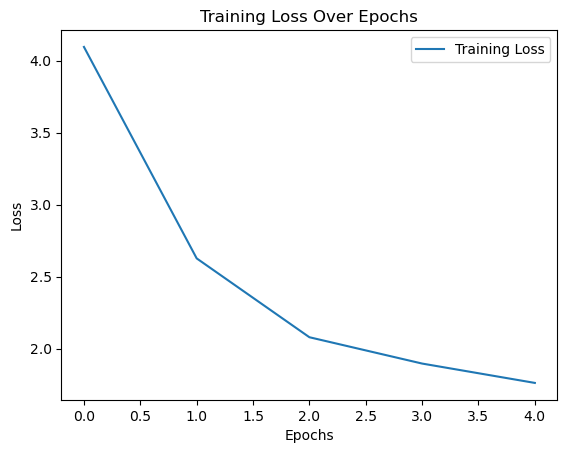

In [52]:
#Plotting loss

plt.plot(epoch_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [33]:
test_input_texts = ["translate LinearB to Greek: " + str(entry) for entry in T5_data_linearb_names_test['linear_b_transliterated_sep']]
test_inputs = tokenizer(test_input_texts, return_tensors='pt', padding=True, truncation=True)

# Evaluate
model.eval() 
with torch.no_grad():
    test_inputs = {k: v.to(device) for k, v in test_inputs.items()}
    test_summary_ids = model.generate(test_inputs['input_ids'], num_beams=4, no_repeat_ngram_size=2, max_length=50)


In [35]:
# Function to measure word similaritieis with Levenshtein

#levenshtein distance
#!pip install textdistance
# from textdistance import levenshtein

def similarity_scores(word1,word2):
    return levenshtein.distance(word1,word2)/max(len(word2),len(word1))

#Test
print(similarity_scores("aetito","aethistos"))

0.3333333333333333


In [38]:
test_predictions = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in test_summary_ids]

comparison_df=[]
#for prediction in test_predictions:
#    print(prediction)
assert(len(test_inputs["input_ids"])==len(test_predictions))

#get linear b transliteration in the original non-names dataset, and in the input test dataset
for i in range(len(test_predictions)):

    cur_prediction_greek=test_predictions[i]
    #print(cur_prediction_greek)
    cur_split_linb_transliteration=T5_data_linearb_names_test["linear_b_transliterated_sep"].iloc[i]
    
    #get the subset of the original non-names dataset which has the same linear_b transliteration
    data_linearb_subset=data_linearb_split[data_linearb_split["linear_b_transliterated_sep"]==cur_split_linb_transliteration]
    if len(data_linearb_subset)==0:
        print(i)
    
    #build up prediction vs. actual, and append the maximum score for the current input
    scores=[]
    indices=[]
    for j in range(len(data_linearb_subset)):
        #print(cur_prediction_greek,"|",data_linearb_subset["greek_transliterate"].iloc[j])
        comparison_df.append([cur_split_linb_transliteration,cur_prediction_greek,\
                              data_linearb_subset["greek_transliterate"].iloc[j]])
        if i<5:print(cur_prediction_greek,data_linearb_subset["greek_transliterate"].iloc[j])
        scores.append(similarity_scores(cur_prediction_greek,data_linearb_subset["greek_transliterate"].iloc[j]))
    best_score_for_subset=max(scores)
    for lst in comparison_df:
        if lst[0]!=cur_split_linb_transliteration:continue
        lst.append(best_score_for_subset)
        

comparison_df=pd.DataFrame(comparison_df,columns=["Original Linear B","Prediction","Actual","Best Levenshtein Similarity Score"])

aetito aethistos
aetito ethizo
adete andetir
adete andetires
adios andriantei
adios andriafi
adios andrios
adios aner
ajamna aiasmena
ajamna aiasmenos
akaros akaranos


In [41]:
#Printing comparison table with Levenshtein scores

print(comparison_df.head(10))
print("\nMean Best Levenshtein Similarity Score:", comparison_df["Best Levenshtein Similarity Score"].mean())

               Original Linear B Prediction      Actual   
0          a<SEP>e<SEP>ti<SEP>to     aetito   aethistos  \
1          a<SEP>e<SEP>ti<SEP>to     aetito      ethizo   
2                a<SEP>de<SEP>te      adete     andetir   
3                a<SEP>de<SEP>te      adete   andetires   
4  a<SEP>di<SEP>ri<SEP>ja<SEP>pi      adios  andriantei   
5  a<SEP>di<SEP>ri<SEP>ja<SEP>pi      adios    andriafi   
6  a<SEP>di<SEP>ri<SEP>ja<SEP>pi      adios     andrios   
7  a<SEP>di<SEP>ri<SEP>ja<SEP>pi      adios        aner   
8         a<SEP>ja<SEP>me<SEP>na     ajamna    aiasmena   
9         a<SEP>ja<SEP>me<SEP>na     ajamna   aiasmenos   

   Best Levenshtein Similarity Score  
0                           0.500000  
1                           0.500000  
2                           0.444444  
3                           0.444444  
4                           0.800000  
5                           0.800000  
6                           0.800000  
7                           0.800000  

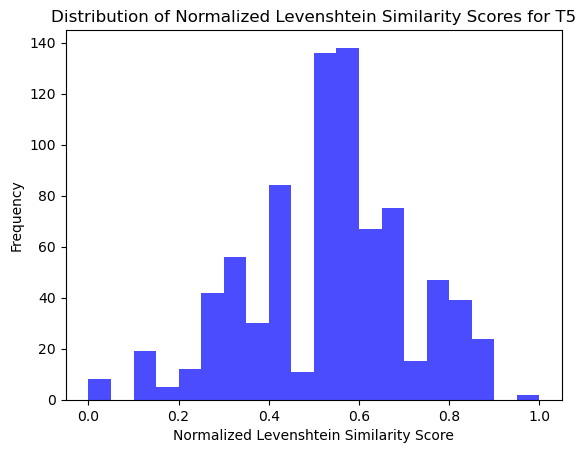

In [50]:
# Extract the 'Best Levenshtein Similarity Score' column values
lev_similarity_scores = comparison_df['Best Levenshtein Similarity Score'].values

# Plot histogram of normalized Levenshtein similarity scores
plt.hist(lev_similarity_scores, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Normalized Levenshtein Similarity Scores for T5')
plt.xlabel('Normalized Levenshtein Similarity Score')
plt.ylabel('Frequency')
plt.show()


In [ ]:
#Code Cemetery

# t5_model = TFT5ForConditionalGeneration.from_pretrained('t5-small')
# t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')


# input_texts = ["translate LinearB to Greek: " + str(entry) for entry in T5_data_linearb_names_train['linear_b_transliterated_sep']]
# inputs = t5_tokenizer(input_texts, return_tensors='tf', padding=True, truncation=True, max_length=512)

# summary_ids = t5_model.generate(inputs['input_ids'],
#                                 num_beams=3,
#                                 no_repeat_ngram_size=3,
#                                 min_length=10,
#                                 max_length=40)

# predictions = [t5_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]

# for prediction in predictions:
#     print(prediction)

# input_texts = ["translate LinearB to Greek: " + str(entry) for entry in T5_data_linearb_names_test['linear_b_transliterated_sep']]
# test_inputs = t5_tokenizer(input_texts, return_tensors='tf', padding=True, truncation=True)

# summary_ids = t5_model.generate(test_inputs['input_ids'],
#                                 num_beams=4,
#                                 no_repeat_ngram_size=2,
#                                 max_length=50)

# predictions = [t5_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]



### BART Model

In [53]:
# Model Settings

BART_lr = 0.0001
BART_epochs = 5

In [ ]:
import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from torch.nn.utils.rnn import pad_sequence


class BART_LinearBToGreek(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {'input_ids': self.input_ids[idx], 'labels': self.labels[idx]}

    def collate_fn(self, batch):
        input_ids, labels = zip(*[d.values() for d in batch])
        input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=1)  
        labels_padded = pad_sequence(labels, batch_first=True, padding_value=1)  
        return {'input_ids': input_ids_padded, 'labels': labels_padded}



#Convert tokenized data to tensors
input_tensors = [torch.tensor(ids) for ids in BART_data_linearb_names_train['linear_b_transliterated_sep_tokenized']]
target_tensors = [torch.tensor(ids) for ids in BART_data_linearb_names_train['greek_transliterate_tokenized']]


train_dataset = BART_LinearBToGreek(input_tensors, target_tensors)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=train_dataset.collate_fn)

# Load the BART model
model = MBartForConditionalGeneration.from_pretrained('facebook/mbart-large-50')

# TESTING 
print("Sample input tensor:", input_tensors[0])
print("Sample target tensor:", target_tensors[0])

assert isinstance(input_tensors[0], torch.Tensor), "Input is not a tensor"
assert isinstance(target_tensors[0], torch.Tensor), "Target is not a tensor"


optimizer = AdamW(model.parameters(), lr=BART_lr)

# Model training

BART_epoch_loss = []
model.train()
for epoch in range(BART_epochs): 
    total_loss = 0

    for input_ids, labels in train_loader:

        # Forward pass
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    BART_epoch_loss.append(avg_loss)

    print(f"Epoch: {epoch}, Loss: {loss.item()}")


In [ ]:
plt.plot(BART_epoch_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
#Tensorize
test_input_ids = pad_sequence([torch.tensor(seq) for seq in BART_data_linearb_names_test['linear_b_sep_tokenized']], 
                              batch_first=True, padding_value=tokenizer.pad_token_id)

# Evaluate
model.eval()
test_predictions = []
with torch.no_grad():
    for input_ids in test_input_ids:
        input_ids = input_ids.unsqueeze(0) 
        output_ids = model.generate(input_ids, num_beams=4, no_repeat_ngram_size=2, max_length=50)
        test_predictions.append(tokenizer.decode(output_ids[0], skip_special_tokens=True))

# The comparison DF
comparison_df = []
for i, prediction in enumerate(test_predictions):
    original_linb = BART_data_linearb_names_test["linear_b_transliterated_sep"].iloc[i]
    actual_greek = BART_data_linearb_names_test["greek_transliterate"].iloc[i]
    score = similarity_scores(prediction, actual_greek)
    comparison_df.append([original_linb, prediction, actual_greek, score])

comparison_df = pd.DataFrame(comparison_df, columns=["Original Linear B", "Prediction", "Actual", "Levenshtein Similarity Score"])

In [ ]:
# Printing comparison table with Levenshtein scores
print(comparison_df.head(10))
print("\nMean Levenshtein Similarity Score:", comparison_df["Levenshtein Similarity Score"].mean())

In [ ]:
# Plot histogram of normalized Levenshtein similarity scores
lev_similarity_scores = comparison_df['Levenshtein Similarity Score'].values
plt.hist(lev_similarity_scores, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Normalized Levenshtein Similarity Scores for BART')
plt.xlabel('Normalized Levenshtein Similarity Score')
plt.ylabel('Frequency')
plt.show()

### Other Models

- XLM_R (Multilingual version of RoBERTa)
- MarianMT (Seq2Sec)
- mT5

## EVALUATION

- Model performance evaluation

In [ ]:
# Evaluation code



## ------ Code Cemetery ------

In [ ]:
# model_directory = './bart.large.tar.gz'
# bart = BARTModel.from_pretrained(model_directory, checkpoint_file='model.pt')
# bart.eval()

In [ ]:
# last_layer_features = bart.extract_features(tokens)

# assert last_layer_features.size() == torch.Size([1, len(tokens), bart.model.encoder.embed_tokens.embedding_dim])

# all_layers = bart.extract_features(tokens, return_all_hiddens=True)

# assert len(all_layers) == bart.model.encoder.layers.__len__() + 1  # +1 for the embedding layer
# assert torch.all(all_layers[-1] == last_layer_features)

In [ ]:
# # Building the COgnate model (sample skeleton)

# config = BertConfig.from_pretrained('bert-base-uncased', output_attentions=True)
# bert_model = BertModel(config)

# class CognatePredictionModel(nn.Module):
#     def __init__(self, bert_model):
#         super(CognatePredictionModel, self).__init__()
#         self.bert = bert_model

#         # BERT outputs a 768-d vector
#         bert_output_size = 768

#         # Additional fully connected layers
#         self.fc1 = nn.Linear(bert_output_size * 2, 512)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(512, 256)
#         # Output layer for binary classification
#         self.fc3 = nn.Linear(256, 1)

#     def forward(self, linear_b_tokens, greek_tokens):
#         # Pass input through BERT, take pooled output
#         outputs_linear_b = self.bert(linear_b_tokens)[1]
#         outputs_greek = self.bert(greek_tokens)[1]

#         # Concatenate the outputs
#         combined = torch.cat((outputs_linear_b, outputs_greek), 1)

#         # Pass through additional layers; placeholders
#         x = self.fc1(combined)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)

#         #print x
#         # Should be tensor with logits

#         return x


In [ ]:
# unique_greek_tokens = set()

# for tokens in data_linearb_names_train['greek']:
#     unique_greek_tokens.update(tokens.split('|'))

# for tokens in data_linearb_names_test['greek']:
#     unique_greek_tokens.update(tokens.split('|'))

# token_to_id = {token: idx for idx, token in enumerate(unique_greek_tokens)}

In [ ]:
# class CognateDataset(Dataset):
#     def __init__(self, linear_b_tokens, greek_tokens, token_to_id, default_id=0):
#         self.linear_b_tokens = linear_b_tokens
#         self.greek_tokens = greek_tokens
#         self.token_to_id = token_to_id
#         self.default_id = default_id

#     def __len__(self):
#         return len(self.linear_b_tokens)

#     def __getitem__(self, idx):
#         linear_b_token_tensor = torch.tensor(self.linear_b_tokens[idx], dtype=torch.long)
#         greek_token_tensor = torch.tensor(self.greek_tokens[idx], dtype=torch.long)

#         return {
#             'linear_b_tokens': linear_b_token_tensor,
#             'greek_tokens': greek_token_tensor
#         }

# train_dataset = CognateDataset(
#     data_linearb_names_train['linear_b_tokens'].tolist(),
#     data_linearb_names_train['greek_tokens'].tolist(),
#     token_to_id,
#     default_id=0
# )

# test_dataset = CognateDataset(
#     data_linearb_names_test['linear_b_tokens'].tolist(),
#     # For test data, you might not have labels or might handle them differently
#     [0] * len(data_linearb_names_test),  # Placeholder if you don't have labels
#     token_to_id,
#     default_id=0
# )

# def collate_fn(batch):
#     linear_b_tokens = [item['linear_b_tokens'] for item in batch]
#     greek_tokens = [item['greek_tokens'] for item in batch]

#     # Pad sequences
#     linear_b_tokens_padded = pad_sequence(linear_b_tokens, batch_first=True, padding_value=tokenizer.pad_token_id)
#     greek_tokens_padded = pad_sequence(greek_tokens, batch_first=True, padding_value=tokenizer.pad_token_id)

#     return {
#         'linear_b_tokens': linear_b_tokens_padded,
#         'greek_tokens': greek_tokens_padded
#     }

# data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [ ]:
# # Model

# model = CognatePredictionModel(bert_model)
# loss_function = nn.BCEWithLogitsLoss()
# optimizer = Adam(model.parameters(), lr=0.001)


# num_epochs = 5
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     correct_predictions = 0
#     total_predictions = 0

#     for batch in data_loader:
#         linear_b_tokens = batch['linear_b_tokens']
#         greek_tokens = batch['greek_tokens']
#         optimizer.zero_grad()

#         outputs = model(linear_b_tokens, greek_tokens)
#         outputs = outputs.squeeze()

#         loss = loss_function(outputs, greek_tokens.float())
#         total_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#         predicted_labels = (outputs > 0).float()
#         correct_predictions += (predicted_labels == greek_tokens).sum().item()
#         total_predictions += greek_tokens.numel()

#     avg_loss = total_loss / len(data_loader)
#     accuracy = correct_predictions / total_predictions
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")